# Two-stage vs. end-to-end optimization: An example in 2D

# Background

This notebook compares (two-stage) predict-then-optimize and (end-to-end) predict-and-optimize formulations on a synthetic problem with one feature and two predictors.

The problem configuration is illustrated below:

![](./predict_and_optimize.png)

The dataset comprises pairs $\{(x_1, c_1), ..., (x_N, c_N)\}$ where
- $x_i$ is an angle (increasing counterclockwise from 3 o'clock)
- $c_i$ is a _noisy_ measurement of the associated unit normal vector (shown in green)

The **prediction problem** is to estimate the continuous relationship $\hat{c} = g(x; \theta) \approx c(x)$ from the discrete dataset.

The **optimization/decision problem** is to estimate points $w(c(x))$ in the blue polygon that minimize $c(x)^\top w$ for each given $x$.

The script presents two formulations. The prediction architecture $g$ is identical in each case, but the training objectives differ:

| Formulation | Approach | Loss function                                              |
| ----------- | --------|------------------------------------------------- |
| two-stage   | The prediction is solved independently to minimize prediction loss | $\frac{1}{N} \sum_k \Vert g(x_k; \theta) - c_k \Vert^2$    |
| end-to-end  | The prediction- & optimization problems are solved in a coupled fashion to minimize decision _regret_ (see [4], Section 3.3.1) | $\frac{1}{N} \sum_k c_k^\top [w(\hat{c}(x_k)) - w(c_k)]$ |

Here $w(c)$ denotes the optimal solution of a linear program:
$$
  w(c) \coloneqq \arg\min_w \{c^\top w: w \in W\} \quad \text{where $W$ is the polygon with blue boundary}
$$

Hence, the end-to-end formulation presents the difficulty of minimizing a quantity involving an $\arg\min$ operation whose graph is _piecewise_ continuous. This notebook demonstrates how gradients of the end-to-end loss function can be computed with the help of the `cvxpylayers` module.

## Notation

Notation is adopted from Section 3 of Tang & Khalil [4]:

| Symbol | In                                                   | Name               | Role                   | Notes                                                                          |
| ------ | ---------------------------------------------------- | ------------------ | ---------------------- | ------------------------------------------------------------------------------ |
| `x`    | $[-\pi, \pi)$                                        | angular coordinate | feature                | input to the predictive model $\hat{c} = g(x; \theta)$                                 |
| `c`, `c_hat` | $\mathbb{R}^2$                                       | normal vector      | target/response        | estimated by the predictive model $\hat{c} = g(x; \theta)$                     |
| `g`    | $[-\pi, \pi) \times \Theta \rightarrow \mathbb{R}^2$ | prediction model   | trainable block/module | trained from sampled data $g(x; \theta) \approx c(x)$                          |
| `w`    | $W \subset \mathbb{R}^2$                             | position           | decision variable      | determined by optimization model $w(x) = \arg\min_w \{ c(x)^\top w: w \in W\}$ |
| $W$    |                                                      | decision set       | feasible region        | a polygon approximating the unit circle                                        |

## Acknowledgement

The problem configuration is inspired by Figure 4 in Sadana et al. [3] and Figure 4 in Tang & Khalil [4].

## Further reading
- [1] [Kotary et al. (2021) _End-to-End Constrained Optimization Learning: A Survey_](https://www.ijcai.org/proceedings/2021/0610.pdf)
- [2] [Lahoud et al. (2025) _Predict-and-Optimize Techniques for Data-Driven Optimization Problems: A Review_](https://doi.org/10.1007/s11063-025-11746-w)
- [3] [Sadana et al. (2025) _A survey of contextual optimization methods for decision-making under uncertainty_](https://doi.org/10.1016/j.ejor.2024.03.020)
- [4] [Tang & Khalil (2024) _PyEPO: a PyTorch-based end-to-end predict-then-optimize library for linear and integer programming_](https://doi.org/10.1007/s12532-024-00255-x)

In [1]:
from typing import Final
import warnings
import cvxpy as cvxpy
from cvxpylayers.torch import CvxpyLayer
from matplotlib import pyplot as plt
import neuromancer as nm
import numpy as np
from numpy.typing import NDArray
import scipy
import torch
from datasources import DataSource

## Parameters

In [2]:
num_vertices: Final = 20
num_samples: Final = 300
num_test: Final = int(num_samples * 0.2)
num_train: Final = int((num_samples - num_test) * 0.8)
num_dev: Final = num_samples - num_train - num_test
eps: Final = 1e-3
x_0: Final = np.asarray(2 * np.pi / num_vertices / 3, dtype=np.float32)
quiver_scale: Final = 2
quiver_options: Final = dict(
    alpha=0.3,
    headaxislength=0,
    headlength=0,
    headwidth=0,
    scale=quiver_scale,
    scale_units="xy",
    width=0.005,
)
rng: Final = np.random.default_rng(seed=0)
norm: Final = dict(mean=0.0, std=0.1)
error: Final = scipy.stats.norm(loc=0.0, scale=0.025)


def position(x: NDArray) -> NDArray:
    """Maps an angle to the boundary of a unit circle."""
    return np.vstack((np.cos(x), np.sin(x)))


def unit_normal(x: NDArray) -> NDArray:
    """Maps an angle to the unit normal of a unit circle."""
    tangent_1 = -np.sin(x)
    tangent_2 = +np.cos(x)
    zeros = np.zeros_like(tangent_1 + tangent_2)
    tangent3 = np.vstack((tangent_1, tangent_2, zeros))
    unit_tangent3 = tangent3 / np.linalg.norm(tangent3, axis=0)
    normal3 = np.cross(unit_tangent3, [0.0, 0.0, 1.0], axis=0)
    return normal3[:2, :]


def wrap(a: NDArray) -> NDArray:
    """Appends a copy of the first column."""
    assert a.ndim == 2 and a.shape[1] != 0
    return np.column_stack((a, a[:, 0]))

## Data generation

In [3]:
x_circle = np.linspace(0.0, 2 * np.pi, 200, dtype=np.float32)
x_vertices = x_0 + np.linspace(0.0, 2 * np.pi, num_vertices)
w_vertices = position(x_vertices)
c_vertices = unit_normal(x_vertices)

x_true = np.linspace(-np.pi / 3, np.pi / 3, num_samples, dtype=np.float32)
w_true = position(x_true)
c_true = unit_normal(x_true)

x_error = error.rvs(size=num_samples, random_state=rng)
c_error = error.rvs(size=(2, num_samples), random_state=rng)
x_observed = np.sort(x_true + x_error)
w_observed = position(x_observed)
c_observed = unit_normal(x_observed) + c_error

raw_data = {"x": x_observed.reshape(-1, 1), "c": c_observed.T}
source_train = DataSource.init(raw_data, slice(0, num_train), name="train", batch_size=32)
source_dev = DataSource.init(raw_data, slice(num_train, -num_test), name="dev")
source_test = DataSource.init(raw_data, slice(-num_test, None), name="test")

## Geometric configuration

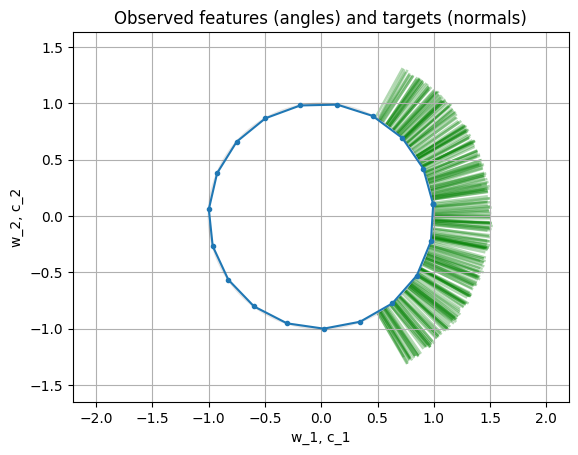

In [4]:
fig, ax = plt.subplots()
ax.plot(*position(x_circle), "k-", alpha=0.1, label="unit circle")
ax.plot(*wrap(w_vertices), ".-", label="boundary(W)")
ax.plot(*wrap(w_vertices + c_vertices / quiver_scale), alpha=0, label=None)
# ax.quiver(*w_vertices, *c_vertices, **quiver_options)
ax.quiver(*w_observed, *c_observed, **quiver_options, color="green")
ax.axis("equal")
ax.set_xlabel("w_1, c_1")
ax.set_ylabel("w_2, c_2")
ax.set_title("Observed features (angles) and targets (normals)")
ax.grid(visible=True)
plt.show(block=False)

## Predictive model

In [5]:
block_predict = nm.blocks.MLP(
    insize=1,
    outsize=2,
    bias=True,
    hsizes=[8] * 2,
    nonlin=torch.nn.SiLU,  # Tanh | Sigmoid | SiLU (Swish) ... smooth
)
num_params = sum(p.numel() for p in block_predict.parameters())
print(f"{num_params} trainable parameters")
assert num_params < num_samples, "probably no hope of a good fit!"

106 trainable parameters


In [6]:
node_predict = nm.Node(block_predict, input_keys=["x"], output_keys=["c_hat"])
x = nm.variable("x")
c = nm.variable("c")
c_hat = nm.variable("c_hat")
objective_predict = nm.Objective((c_hat - c) ** 2, name="squared_error")
circle: nm.Constraint = c_hat[:, 0] ** 2 + c_hat[:, 1] ** 2 == torch.ones_like(
    c_hat[:, 0]
)
circle.name = "circle_constraint"

problem_predict = nm.Problem(
    nodes=[node_predict],
    loss=nm.PenaltyLoss(objectives=[objective_predict], constraints=[circle]),
)
optimizer_predict = torch.optim.AdamW(problem_predict.parameters(), lr=0.001)
trainer_predict = nm.Trainer(
    problem_predict,
    source_train.loader,
    source_dev.loader,
    source_test.loader,
    optimizer_predict,
    epochs=2000,
    patience=100,
)

best_model_predicted = trainer_predict.train()
problem_predict.load_state_dict(best_model_predicted)

epoch: 0  train_loss: 1.2264492511749268
epoch: 1  train_loss: 1.1767792701721191
epoch: 2  train_loss: 1.1248515844345093
epoch: 3  train_loss: 1.070602297782898
epoch: 4  train_loss: 1.0135191679000854
epoch: 5  train_loss: 0.9524833559989929
epoch: 6  train_loss: 0.888143002986908
epoch: 7  train_loss: 0.8185791969299316
epoch: 8  train_loss: 0.7422205805778503
epoch: 9  train_loss: 0.6588281989097595
epoch: 10  train_loss: 0.5653843283653259
epoch: 11  train_loss: 0.4608781039714813
epoch: 12  train_loss: 0.34227490425109863
epoch: 13  train_loss: 0.2206537276506424
epoch: 14  train_loss: 0.22461624443531036
epoch: 15  train_loss: 0.18533571064472198
epoch: 16  train_loss: 0.17371107637882233
epoch: 17  train_loss: 0.15506760776042938
epoch: 18  train_loss: 0.14412793517112732
epoch: 19  train_loss: 0.1363283395767212
epoch: 20  train_loss: 0.12860523164272308
epoch: 21  train_loss: 0.12167521566152573
epoch: 22  train_loss: 0.1155606284737587
epoch: 23  train_loss: 0.1103641986846

<All keys matched successfully>

In [7]:
x_eval = torch.tensor(
    np.linspace(x_observed[0], x_observed[-1], 5 * x_observed.size).reshape(-1, 1),
    dtype=torch.float32,
)
x_eval = x_eval.to(next(block_predict.parameters()).device)
with torch.no_grad():
    c_predicted = block_predict(x_eval).cpu().numpy().T
    assert c_predicted.shape == (2, x_eval.numel())

## Optimization model

In [8]:
c_cvxpy = cvxpy.Parameter(shape=(2,), name="c")
w_cvxpy = cvxpy.Variable(shape=(2,), name="w")
λ_cvxpy = cvxpy.Variable(shape=(num_vertices,), name="p")
problem_cvxpy = cvxpy.Problem(
    objective=cvxpy.Minimize(c_cvxpy @ w_cvxpy),
    constraints=[
        w_cvxpy == w_vertices @ λ_cvxpy,
        cvxpy.sum(λ_cvxpy) == 1.0,
        λ_cvxpy >= 0.0,
    ],
)


def objective_value(c: NDArray, solver: str = cvxpy.ECOS) -> np.float64:
    global c_cvxpy, problem_cvxpy
    c_cvxpy.value = c / np.linalg.norm(c)
    problem_cvxpy.solve(solver=solver, verbose=False)
    return problem_cvxpy.objective.value


z_star_observed = np.fromiter(map(objective_value, c_observed.T), dtype=np.float64)
z_star_predicted = np.fromiter(map(objective_value, c_predicted.T), dtype=np.float64)

## Two-stage predict-then-optimize solution

In [9]:
raw_data_new = {**raw_data, "z_star": z_star_observed.reshape(-1, 1)}
source_train_new = DataSource.init(raw_data_new, slice(0, num_train), name="train")
source_dev_new = DataSource.init(raw_data_new, slice(num_train, -num_test), name="dev")
source_test_new = DataSource.init(raw_data_new, slice(-num_test, None), name="test")

## End-to-end predict-and-optimize solution

In [10]:
layer_cvxpy = CvxpyLayer(problem_cvxpy, parameters=[c_cvxpy], variables=[w_cvxpy])
node_optimize = nm.Node(layer_cvxpy, input_keys=["c_hat"], output_keys=["w"])
w = nm.variable("w")
z_star = nm.variable("z_star")
objective_spo = nm.Objective(c * w - z_star)
problem_combined = nm.Problem(
    nodes=[node_predict, node_optimize],
    loss=nm.PenaltyLoss(objectives=[objective_spo], constraints=[circle]),
)
optimizer_combined = torch.optim.AdamW(problem_combined.parameters(), lr=0.001)
trainer_combined = nm.Trainer(
    problem_combined,
    source_train_new.loader,
    source_dev_new.loader,
    source_test_new.loader,
    optimizer_combined,
    epochs=2000,
    patience=100,
)

# Set to False to eliminate costly training while testing the plots etc.
if True:
    best_model_combined = trainer_combined.train()
    problem_combined.load_state_dict(best_model_combined)
else:
    problem_combined.load_state_dict(best_model_predicted)  # WARNING!
    warnings.warn("Skipping training for end-to-end formulation!")

epoch: 0  train_loss: 0.5109784007072449
epoch: 1  train_loss: 0.5075511932373047
epoch: 2  train_loss: 0.5051932334899902
epoch: 3  train_loss: 0.5041967630386353
epoch: 4  train_loss: 0.5040296912193298
epoch: 5  train_loss: 0.5031864047050476
epoch: 6  train_loss: 0.503200113773346
epoch: 7  train_loss: 0.5032922625541687
epoch: 8  train_loss: 0.5030282139778137
epoch: 9  train_loss: 0.5028342604637146
epoch: 10  train_loss: 0.5028588175773621
epoch: 11  train_loss: 0.5030500888824463
epoch: 12  train_loss: 0.5028055310249329
epoch: 13  train_loss: 0.5031351447105408
epoch: 14  train_loss: 0.5030110478401184
epoch: 15  train_loss: 0.5035385489463806
epoch: 16  train_loss: 0.5032143592834473
epoch: 17  train_loss: 0.5032082796096802
epoch: 18  train_loss: 0.5030472278594971
epoch: 19  train_loss: 0.5031649470329285
epoch: 20  train_loss: 0.5029408931732178
epoch: 21  train_loss: 0.5029637813568115
epoch: 22  train_loss: 0.5030340552330017
epoch: 23  train_loss: 0.5032848715782166
epo

In [11]:
with torch.no_grad():
    c_combined = block_predict(x_eval).cpu().numpy().T
    assert c_combined.shape == (2, x_eval.numel())

z_star_combined = np.fromiter(map(objective_value, c_combined.T), dtype=np.float64)

## Visual comparison

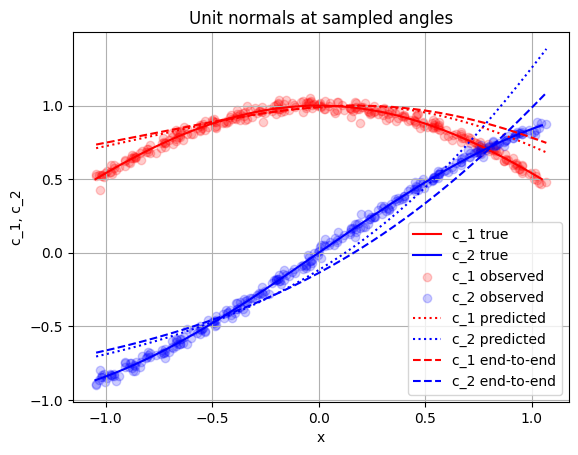

In [12]:
# fmt: off
fig, ax = plt.subplots()
ax.plot(x_true, c_true[0, :], color="r", linestyle="solid", label="c_1 true")
ax.plot(x_true, c_true[1, :], color="b", linestyle="solid", label="c_2 true")
ax.scatter(x_observed, c_observed[0, :], color="r", label="c_1 observed", alpha=0.2)
ax.scatter(x_observed, c_observed[1, :], color="b", label="c_2 observed", alpha=0.2)
ax.plot(x_eval, c_predicted[0, :], color="r", linestyle="dotted", label="c_1 predicted")
ax.plot(x_eval, c_predicted[1, :], color="b", linestyle="dotted", label="c_2 predicted")
ax.plot(x_eval, c_combined[0, :], color="r",  linestyle="dashed", label="c_1 end-to-end")
ax.plot(x_eval, c_combined[1, :], color="b",  linestyle="dashed", label="c_2 end-to-end")
# fmt: on
ax.set_xlabel("x")
ax.set_ylabel("c_1, c_2")
ax.set_title("Unit normals at sampled angles")
ax.grid(visible=True)
ax.legend()
plt.show(block=False)

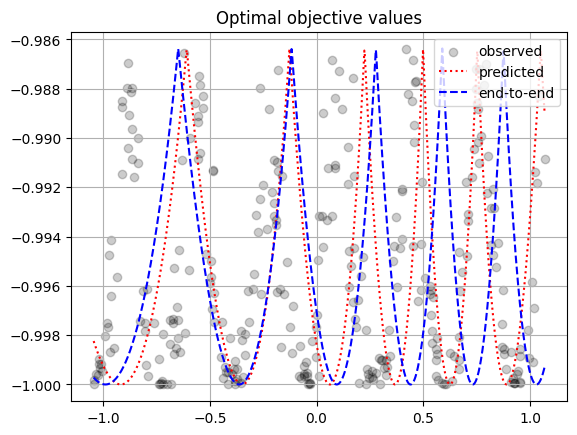

In [13]:
fig, ax = plt.subplots()
# fmt: off
ax.scatter(x_observed, z_star_observed, color="k", label="observed", alpha=0.2)
ax.plot(x_eval, z_star_predicted, color="r", linestyle="dotted", label="predicted")
ax.plot(x_eval, z_star_combined, color="b", linestyle="dashed", label="end-to-end")
# fmt: on
ax.grid(visible=True)
ax.legend()
ax.set_title("Optimal objective values")
plt.show(block=False)

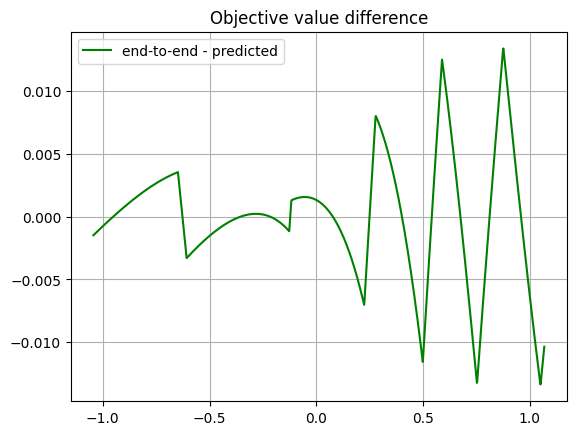

In [14]:
fig, ax = plt.subplots()
# fmt: off
ax.plot(x_eval, z_star_combined - z_star_predicted, color="g", label="end-to-end - predicted")
# fmt: on
ax.grid(visible=True)
ax.legend()
ax.set_title(f"Objective value difference")
plt.show(block=False)